In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
from pathlib import Path
from itertools import product

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import pandas as pd
import seaborn as sns

import sbibm
from sbibm.utils.io import get_tensor_from_csv

import sbi.analysis as analysis

from notebook import nre_gamma_default, prepare_df_for_plot, get_metrics

In [4]:
df_prior = get_metrics(
    [
        "metrics-prior.csv",
    ],
    "prior",
)
df_joint = get_metrics(
    [
        "metrics-joint.csv",
    ],
    "joint",
)

df = pd.concat([df_joint, df_prior], ignore_index=True)
df["gamma"] = df["gamma"].fillna(nre_gamma_default)

print(len(df))
print(df.columns)
print(df["algorithm"].unique())
print(df["task"].unique())
print(df["num_contrastive_parameters"].unique())
df.head()

832
Index(['task', 'seed', 'algorithm', 'K', 'num_atoms',
       'num_contrastive_parameters', 'gamma', 'extra_theta_factor',
       'hidden_features', 'num_blocks', 'AVG_LOG_RATIO', 'RT', 'C2ST_Z-01',
       'MMD-01', 'MEDDIST-01', 'NLTP-01', 'C2ST_Z-02', 'MMD-02', 'MEDDIST-02',
       'NLTP-02', 'C2ST_Z-03', 'MMD-03', 'MEDDIST-03', 'NLTP-03', 'C2ST_Z-04',
       'MMD-04', 'MEDDIST-04', 'NLTP-04', 'C2ST_Z-05', 'MMD-05', 'MEDDIST-05',
       'NLTP-05', 'C2ST_Z-06', 'MMD-06', 'MEDDIST-06', 'NLTP-06', 'C2ST_Z-07',
       'MMD-07', 'MEDDIST-07', 'NLTP-07', 'C2ST_Z-08', 'MMD-08', 'MEDDIST-08',
       'NLTP-08', 'C2ST_Z-09', 'MMD-09', 'MEDDIST-09', 'NLTP-09', 'C2ST_Z-10',
       'MMD-10', 'MEDDIST-10', 'NLTP-10', 'NLTP', 'num_simulations_simulator',
       'path', 'folder', 'reuse', 'expr'],
      dtype='object')
['NRE-B' 'CNRE']
['slcp' 'two_moons' 'gaussian_mixture']
[200 100 150  10  25  75   2  50]


,task,seed,algorithm,K,num_atoms,num_contrastive_parameters,gamma,extra_theta_factor,hidden_features,num_blocks,...,C2ST_Z-10,MMD-10,MEDDIST-10,NLTP-10,NLTP,num_simulations_simulator,path,folder,reuse,expr
0,slcp,980488309,NRE-B,200,200,200,inf,False,50,2,...,0.82350,0.042112,2.018930,NaN,NaN,20504576.0,/home/ben/sci/cnre/infinite/joint/20-18-33/15,15,NaN,joint
1,two_moons,2456924169,NRE-B,100,100,100,inf,False,50,2,...,0.58885,0.002229,0.093457,NaN,NaN,20504576.0,/home/ben/sci/cnre/infinite/joint/20-18-33/5,5,NaN,joint
2,gaussian_mixture,4264851724,NRE-B,150,150,150,inf,False,50,2,...,0.69175,0.010666,0.745870,NaN,NaN,20504576.0,/home/ben/sci/cnre/infinite/joint/20-18-33/22,22,NaN,joint
3,slcp,2733803972,NRE-B,10,10,10,inf,False,50,2,...,0.87740,0.125824,2.029766,NaN,NaN,20504576.0,/home/ben/sci/cnre/infinite/joint/20-18-33/9,9,NaN,joint
4,slcp,3120623302,NRE-B,25,25,25,inf,False,50,2,...,0.87680,0.126860,1.861489,NaN,NaN,20504576.0,/home/ben/sci/cnre/infinite/joint/20-18-33/10,10,NaN,joint


In [5]:
# go to long
df_wide = pd.wide_to_long(
    df, 
    ["C2ST_Z"], 
    i=["task", "algorithm", "num_contrastive_parameters", "gamma", "num_blocks", "seed", "expr"], 
    j="num_observation", 
    sep="-"
)

# groupby drops NaNs
grp = df_wide.groupby([
    "task",
    "algorithm",
    "num_contrastive_parameters",
    "gamma",
    "num_blocks",
    "expr",
])
grp.count()
# grp.aggregate({
#     "C2ST_Z": ["mean", "std"],
# })

MMD-10  \
task             algorithm num_contrastive_parameters gamma num_blocks expr            
gaussian_mixture CNRE      2                          0.001 2          joint      10   
                                                                       prior      10   
                                                            3          joint      10   
                                                                       prior      20   
                                                      0.010 2          joint      10   
...                                                                              ...   
two_moons        NRE-B     150                        inf   3          prior      10   
                           200                        inf   2          joint      10   
                                                                       prior      10   
                                                            3          joint      10   
                                                                       prior      10   

                                                                              MEDDIST-09  \
task             algorithm num_contrastive_parameters gamma num_blocks expr                
gaussian_mixture CNRE      2                          0.001 2          joint          10   
                                                                       prior          10   
                                                            3          joint          10   
                                                                       prior          20   
                                                      0.010 2          joint          10   
...                                                                                  ...   
two_moons        NRE-B     150                        inf   3          prior          10   
                           200                        inf   2          joint          10   
                                                                       prior          10   
                                                            3          joint          10   
                                                                       prior          10   

                                                                              num_simulations_simulator  \
task             algorithm num_contrastive_parameters gamma num_blocks expr                               
gaussian_mixture CNRE      2                          0.001 2          joint                         10   
                                                                       prior                         10   
                                                            3          joint                         10   
                                                                       prior                         20   
                                                      0.010 2          joint                         10   
...                                                                                                 ...   
two_moons        NRE-B     150                        inf   3          prior                         10   
                           200                        inf   2          joint                         10   
                                                                       prior                         10   
                                                            3          joint                         10   
                                                                       prior                         10   

                                                                              RT  \
task             algorithm num_contrastive_parameters gamma num_blocks expr        
gaussian_mixture CNRE      2                          0.001 2          joint  10   
                                                                       prior  10   
        

## joint

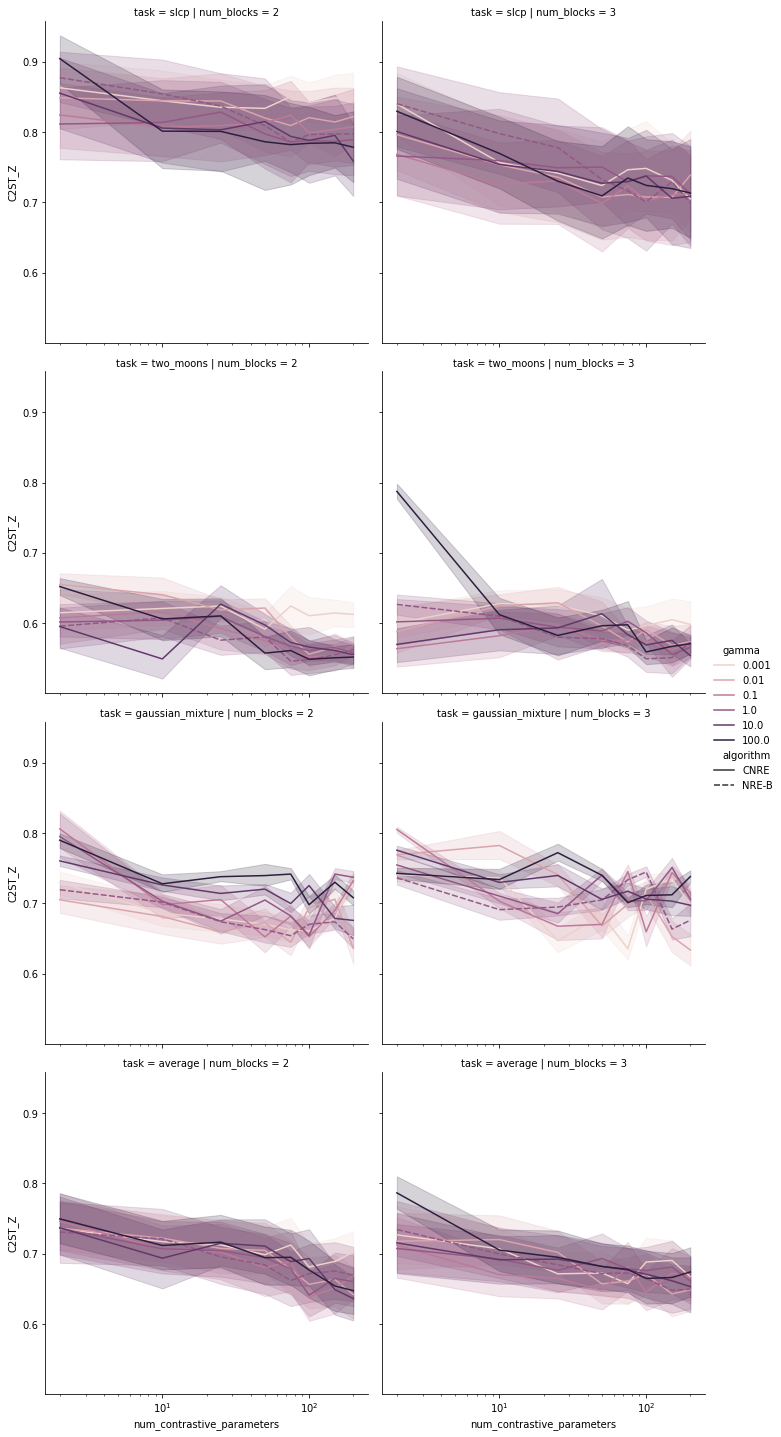

In [6]:
fg = sns.relplot(
    data=prepare_df_for_plot(df_wide, "joint"),
    x="num_contrastive_parameters",
    y="C2ST_Z",
    hue="gamma",
    style="algorithm",
    style_order=["CNRE", "NRE-B"],
    row="task",
    col="num_blocks",
    kind="line",
    hue_norm=LogNorm(),
)
for ax in fg.axes.flatten():
    ax.set(xscale='log') 

## prior

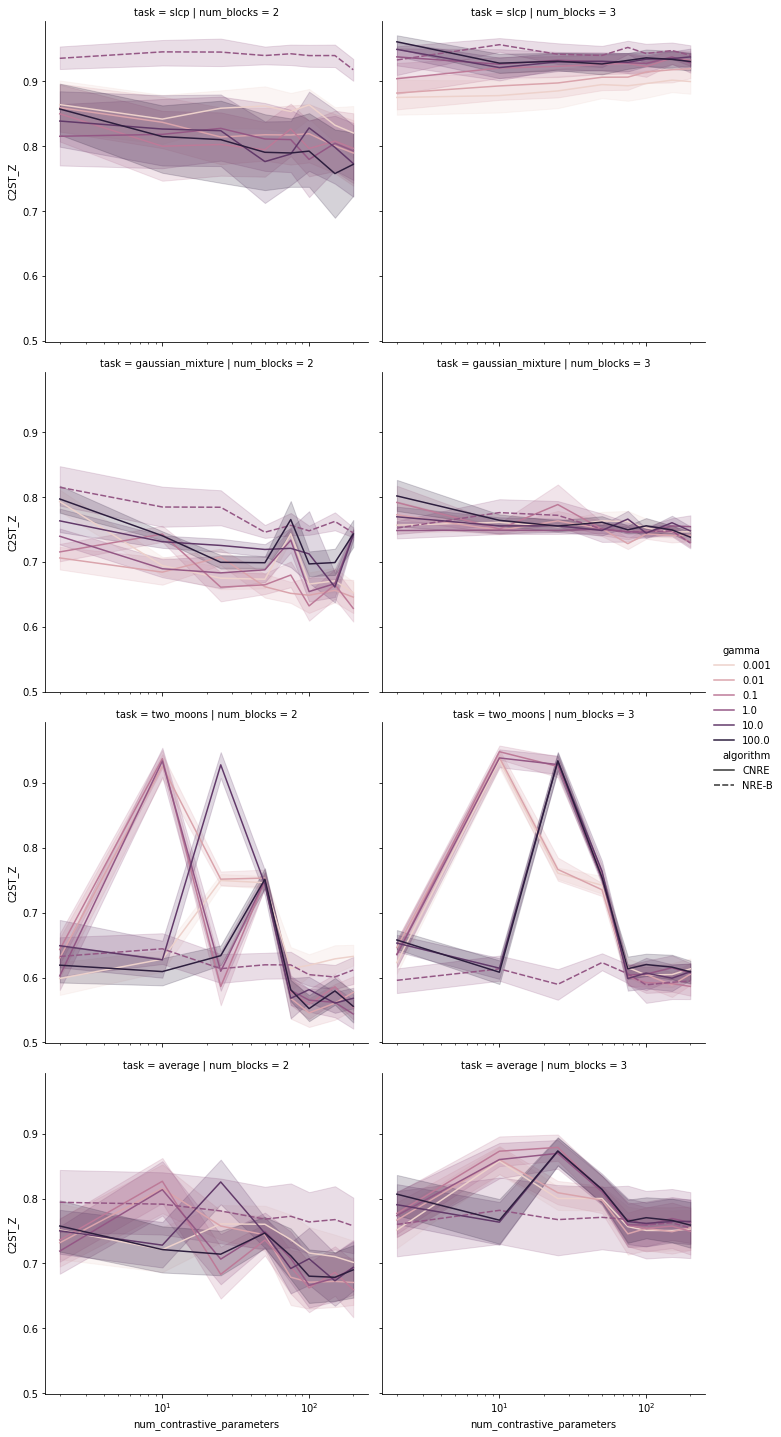

In [7]:
fg = sns.relplot(
    data=prepare_df_for_plot(df_wide, "prior"),
    x="num_contrastive_parameters",
    y="C2ST_Z",
    hue="gamma",
    style="algorithm",
    style_order=["CNRE", "NRE-B"],
    row="task",
    col="num_blocks",
    kind="line",
    hue_norm=LogNorm(),
)
for ax in fg.axes.flatten():
    ax.set(xscale='log') 

In [17]:
df_wide.sort_values("C2ST_Z")

MMD-10  \
task             algorithm num_contrastive_parameters gamma   num_blocks seed       expr  num_observation             
two_moons        CNRE      150                        1.000   3          2898808666 joint 2                0.000197   
                           100                        0.001   3          2167386326 joint 2                0.000531   
                           150                        1.000   3          2898808666 joint 1                0.000197   
                           10                         10.000  2          3673042444 joint 1                0.000882   
                           150                        100.000 2          746039250  joint 6                0.001404   
...                                                                                                             ...   
slcp             CNRE      2                          100.000 3          1898905594 prior 4                0.243495   
gaussian_mixture CNRE      100                        10.000  2          2870261173 prior 9                0.019155   
slcp             CNRE      2                          100.000 3          3491365323 prior 4                0.209373   
                 NRE-B     25                         inf     2          3851445216 prior 7                0.102592   
                 CNRE      2                          100.000 3          1898905594 prior 8                0.243495   

                                                                                                           MEDDIST-09  \
task             algorithm num_contrastive_parameters gamma   num_blocks seed       expr  num_observation               
two_moons        CNRE      150                        1.000   3          2898808666 joint 2                  0.091035   
                           100                        0.001   3          2167386326 joint 2                  0.090333   
                           150                        1.000   3          2898808666 joint 1                  0.091035   
                           10                         10.000  2          3673042444 joint 1                  0.092241   
                           150                        100.000 2          746039250  joint 6                  0.090147   
...                                                                                                               ...   
slcp             CNRE      2                          100.000 3          1898905594 prior 4                 10.535357   
gaussian_mixture CNRE      100                        10.000  2          2870261173 prior 9                 16.550907   
slcp             CNRE      2                          100.000 3          3491365323 prior 4                 10.659145   
                 NRE-B     25                         inf     2          3851445216 prior 7                  8.155268   
                 CNRE      2                          100.000 3          1898905594 prior 8                 10.535357   

                                                                                                           num_simulations_simulator  \
task             algorithm num_contrastive_parameters gamma   num_blocks seed       expr  num_observation                              
two_moons        CNRE      150                        1.000   3          2898808666 joint 2                               21508096.0   
                           100                        0.001   3          2167386326 joint 2                               21508096.0   
                           150                        1.000   3          2898808666 joint 1                               21508096.0   
                           10                         10.000  2          3673042444 joint 1                               21508096.0   
                           150                        100.000 2          746039250  joint 6                               21508096.0   
...                                